In [3]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.signal import deconvolve
import holidays
from analysis import *
import pickle

In [2]:
def fourierExtrapolation(x, n_predict, n_harm=10):
    n = x.size

    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)

    x_notrend = x - p[0] * t - p[1]            # signal detrended 
    x_freqdom = np.fft.fft(x_notrend)   # signal in frequencies domain
    f = np.fft.fftfreq(n)               # frequencies

    indexes = list(range(n))
    indexes.sort(key= lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sign = np.zeros(t.size)

    for i in indexes[:1 + n_harm * 2]:
        amplitude = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sign += amplitude * np.cos(2 * np.pi * f[i] * t + phase)
    
    return restored_sign + p[0] * t + p[1]

In [ ]:
file = open("./Data/festivities.pkl", "rb")
poland_holidays = pickle.load(file)
file.close()

In [95]:
poland_holidays = holidays.CountryHoliday('Poland')

In [96]:
data = pd.read_csv("Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)

Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0

Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric = Electric[['Date', 'Seconds', 'Load']]
Electric['Day'] = Electric['Date'].dt.day_name()
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour
Electric['Holiday'] = Electric.Date.apply(lambda x: x in poland_holidays)
Electric.loc[Electric.Day.isin(['Sunday']) ,'Holiday'] = True
Electric.columns

Index(['Date', 'Seconds', 'Load', 'Day', 'Minutes', 'Hour', 'Holiday'], dtype='object')

In [6]:
Electric.Day.unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [122]:
cut_dw, cut_up = '2008-01-07', '2015-12-28'
mask = (Electric['Date'] >= cut_dw) & (Electric['Date'] < cut_up)
train_set = Electric[mask].reset_index(drop=True)
cut_dw, cut_up = '2015-12-28', '2016-12-26'
mask = (Electric['Date'] >= cut_dw) & (Electric['Date'] < cut_up)
test_set = Electric[mask].reset_index(drop=True)

In [86]:
245376/315648,    70273/315648 

(0.7773722627737226, 0.22263090531224655)

In [4]:
signal_reconstr = fourierExtrapolation(Electric.Load.values, int(96*7), n_harm=1000)

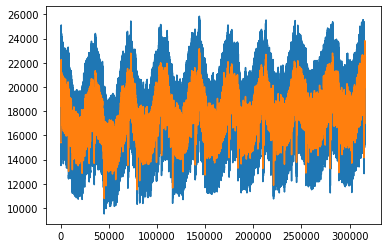

In [5]:
plt.plot(Electric.Load.values)
plt.plot(signal_reconstr)

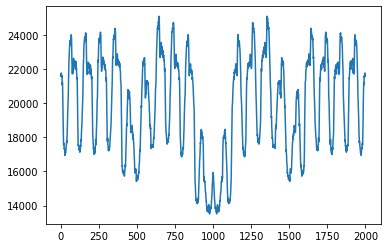

In [6]:
plt.plot(np.concatenate([Electric.Load.values[:1000][::-1], Electric.Load.values[:1000]]))
#plt.xlim(900,1000)

In [7]:
# prima di fare le analisi simili a quelle di gioacchino bisogna estendere 
# il segnale in modo tale da eliminare gli effetti sui bordi dati dalla
# convoluzione.

In [125]:
working_days = train_set[~train_set.Holiday].reset_index(drop=True)
festivities = train_set[train_set.Holiday].reset_index(drop=True)

In [126]:
f = {'Load': ['mean', 'std']}
pred_working_days = working_days.groupby(['Day', 'Hour', 'Minutes']).agg(f)
pred_working_days = pred_working_days.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']]
pred_festivities = festivities.groupby(['Hour', 'Minutes']).agg(f)

a = pred_working_days.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']].to_numpy()
b = pred_festivities.to_numpy()

psfs = np.concatenate([a, b])

In [127]:
psf = psfs[:, 0].copy()
psf_low = (psf - 1.96 * psfs[:, 1]).copy()
psf_up = (psf + 1.96 * psfs[:, 1]).copy()

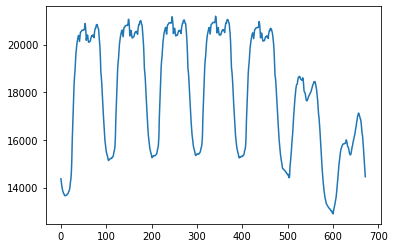

In [128]:
plt.plot(psf)

In [223]:
load = test_set.Load.to_numpy()

def deconvolution(signal, psf, window=96):
    deconv = np.zeros(len(signal))
    for i in range(len(signal) // window):
        deconv[i*window:(i+1)*window +1] = deconvolve(signal[(i*window) : (i+2)*window], psf)[0]
        deconv[(i+1)*window:(i+2)*window+1] = deconvolve(signal[(i+1)*window:(i+3)*window], psf)[0]
    return deconv


deconv_psf = deconvolution(load, psf, len(psf))
deconv_psfq1 = deconvolution(load, psf_low, len(psf))
deconv_psfq2 = deconvolution(load, psf_up, len(psf))

In [238]:
from scipy.signal import find_peaks

cut_value = np.round(deconv_psf[-1], 8)
ind = np.where(np.round(deconv_psf, 8) == cut_value)[0]
deconv_psf[ind[1:]] = 0

x_peaks = find_peaks(deconv_psf, distance=96*7)[0]
x_peaks = np.array([0] + [x for x in x_peaks])

peaks = deconv_psf[x_peaks]

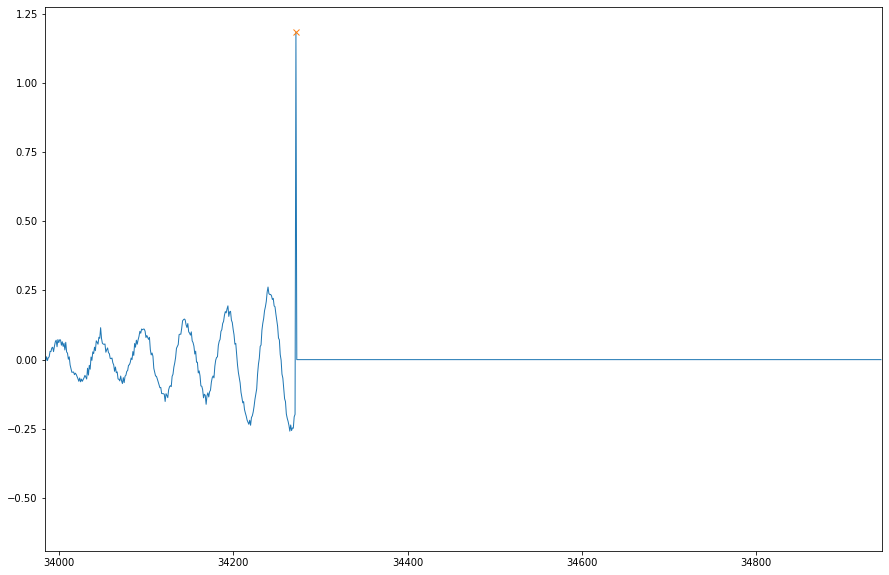

In [240]:
plt.figure(figsize=(15, 10))
n = len(deconv_psf)
slic = range(0, n, 1)
plt.plot(deconv_psf, lw=1)
plt.plot(x_peaks, peaks, 'x')
m = len(deconv_psf[slic])
plt.xlim(n-96*10, n)
plt.show()

In [ ]:
tmp = deconv_psf.copy()

tmp[tmp < peaks.min()] = 0

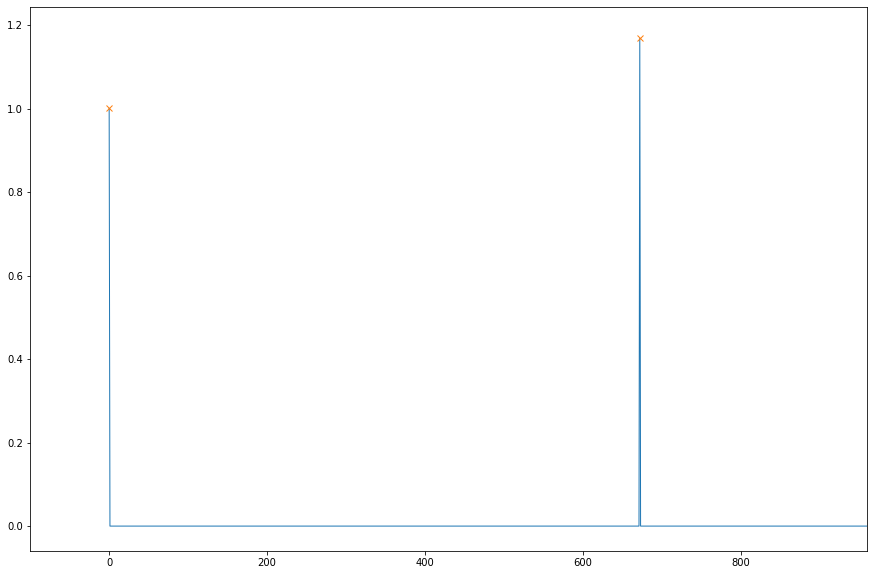

'plt.figure(figsize=(15, 10))\nslic = range(0, 96*70, 1)\nplt.plot(deconv_psfq1[slic], lw=1)\nm = len(deconv_psfq1[slic])\nplt.show()\n#plt.plot(np.arange(m), [1.1]*m)\n\n\nplt.figure(figsize=(15, 10))\nplt.plot(deconv_psfq2[slic], lw=1)\nm = len(deconv_psfq2[slic])\nplt.show()'

In [241]:
plt.figure(figsize=(15, 10))
n = len(deconv_psf)
slic = range(0, n, 1)
plt.plot(tmp, lw=1)
plt.plot(x_peaks, peaks, 'x')
m = len(deconv_psf[slic])
plt.xlim(-100, 96*10)
plt.show()


"""plt.figure(figsize=(15, 10))
slic = range(0, 96*70, 1)
plt.plot(deconv_psfq1[slic], lw=1)
m = len(deconv_psfq1[slic])
plt.show()
#plt.plot(np.arange(m), [1.1]*m)


plt.figure(figsize=(15, 10))
plt.plot(deconv_psfq2[slic], lw=1)
m = len(deconv_psfq2[slic])
plt.show()"""

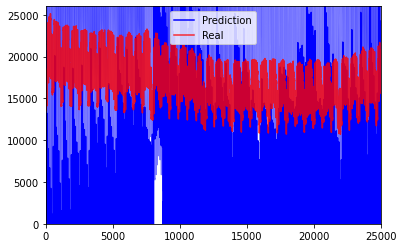

In [156]:
load_psf = np.convolve(deconv_psf, psf, 'valid')[:-96]
load_q1 = np.convolve(deconv_psfq1, psf_q1, 'valid')[:-96]
load_q2 = np.convolve(deconv_psfq2, psf_q2, 'valid')[:-96]
t = range(len(load_psf))

plt.plot(load_psf, 'b', label='Prediction')
plt.fill_between(x=t, y1=load_q1, y2=load_q2, color='b', alpha=0.5)
plt.plot(load, '-r', alpha=0.8, label='Real')
plt.legend()

In [253]:
load_psf = np.convolve(tmp, psf, 'valid')[:-96*7]

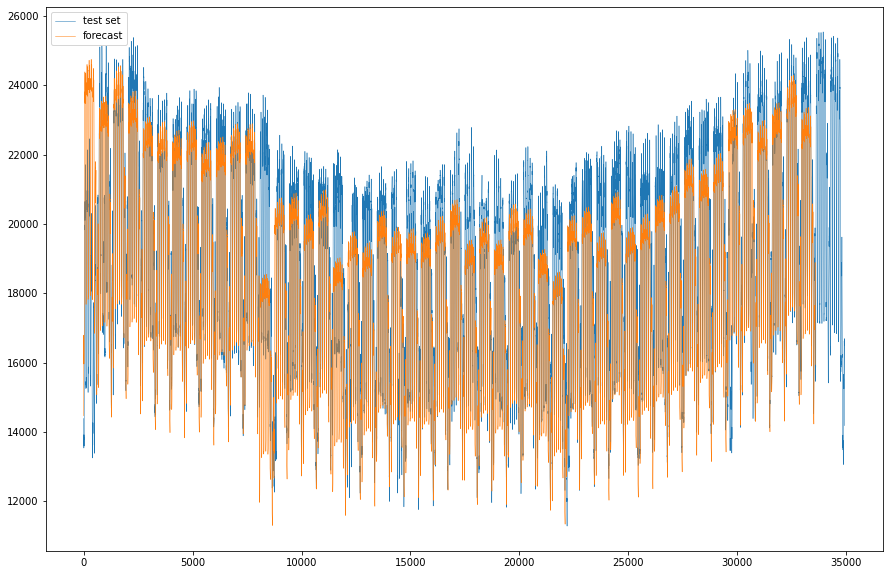

In [254]:
plt.figure(figsize=(15, 10))
plt.plot(test_set.Load, lw=0.5, label='test set')
plt.plot(load_psf, lw=0.5, label='forecast')
plt.legend()